A.L.E: Arcade Learning Environment (version 0.10.1+6a7e0ae)
[Powered by Stella]


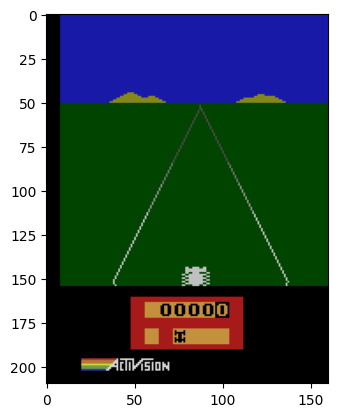

In [6]:
import gymnasium as gym
from gymnasium.wrappers import AtariPreprocessing, FrameStackObservation
import ale_py
import matplotlib
import matplotlib.pyplot as plt
import cv2
import numpy as np

gym.register_envs(ale_py)
env = gym.make("Enduro-v4")
state, _ = env.reset()
plt.imshow(state)

state.shape
env.close()

In [2]:
# def preprocess_frame(frame):
#     """
#     Preprocesses a (210, 160, 3) Atari frame by:
#     - Converting to grayscale
#     - Resizing to (110, 84)
#     - Cropping to (84, 84)
    
#     Parameters:
#         frame (np.array): The raw RGB frame of shape (210, 160, 3)
        
#     Returns:
#         np.array: The preprocessed grayscale frame of shape (84, 84)
#     """
#     # Step 1: Convert RGB to grayscale
#     grayscale_frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    
#     # Step 2: Resize to (110, 84)
#     resized_frame = cv2.resize(grayscale_frame, (84, 110), interpolation=cv2.INTER_AREA)
    
#     # Step 3: Crop to (84, 84)
#     cropped_frame = resized_frame[18:102, :]  # Crop from height (18, 102), width (0, 84)
    
#     return cropped_frame

In [69]:
env = gym.make("Enduro-v4")
env = preprocess_env(env)
STATES = env.observation_space.shape
ACTIONS = env.action_space.n

# STATES = (4, 84, 84) Actions = 9
agent = DQNAgent(replace_target_cnt=100, env=env, state_space=STATES, action_space=ACTIONS)
# agent.train()


MPS FOUND
Target network replaced


In [11]:
def preprocess_env(env):
    # env = AtariPreprocessing(env, screen_size=(84, 84),frame_skip=1, grayscale_obs=True)
    env = AtariPreprocessing(env, frame_skip=1, grayscale_obs=True)
    env = FrameStackObservation(env, 4)
    return env

In [7]:
env = gym.make("Enduro-v0")
env = preprocess_env(env)


/Users/tariqgeorges/Documents/Riq Coding/Nov 24/game-rl/atari-rl/lib/python3.9/site-packages/gymnasium/envs/registration.py:517: DeprecationWarning: WARN: The environment Enduro-v0 is out of date. You should consider upgrading to version `v4`.
  logger.deprecation(


In [29]:
state, _ = env.reset()
print(state)
action = env.action_space.sample()
state_, reward, done, _, info = env.step(action)

# plt.imshow(state[3])
# plt.title("Preprocessed Frame")
# plt.show()

[[[ 0  0  0 ... 41 41 41]
  [ 0  0  0 ... 41 41 41]
  [ 0  0  0 ... 41 41 41]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ... 41 41 41]
  [ 0  0  0 ... 41 41 41]
  [ 0  0  0 ... 41 41 41]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ... 41 41 41]
  [ 0  0  0 ... 41 41 41]
  [ 0  0  0 ... 41 41 41]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ... 41 41 41]
  [ 0  0  0 ... 41 41 41]
  [ 0  0  0 ... 41 41 41]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]]


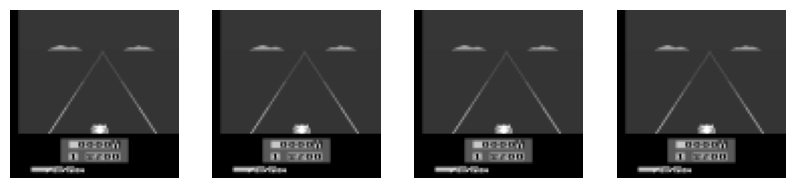

In [13]:
# Plot the 4 frames in a 1x4 grid
plt.figure(figsize=(10, 8))
for idx in range(state.shape[0]):
    plt.subplot(1, 4, idx + 1)
    plt.imshow(state[idx, :, :], cmap="gray")
    plt.axis("off")  # Turn off axis for better visualization
plt.show()

In [19]:
env.close()

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import namedtuple, deque
from itertools import count
import random
import math

Transition = namedtuple('Transition',
                        ('state', 'action', 'reward', 'next_state', 'done'))

class ReplayMemory(object):

    def __init__(self, capacity):
        # self.memory = deque([], maxlen=capacity)
        self.memory = []
        self.capacity = capacity
        self.pointer = 0  # Track the next position to overwrite if needed

    def push(self, *args):
        """Save a transition"""
        if len(self.memory) < self.capacity:
            # If buffer is not full, add new transition normally
            self.memory.append(None)
        
        # If buffer is full, overwrite the oldest element
        self.memory[self.pointer] = Transition(*args)
        # Update the pointer
        self.pointer = int((self.pointer + 1) % self.capacity)

    def sample(self, batch_size):
        batch = random.sample(self.memory, batch_size)
        batch = Transition(*zip(*batch))
        return batch

    def __len__(self):
        return len(self.memory)

In [78]:
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions, filename, hidden_dim=512):
        super(DQN, self).__init__()

        C, H, W = n_observations

        self.conv = nn.Sequential(
            nn.Conv2d(C, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        conv_out_size = self._get_conv_out(n_observations)
        
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, n_actions)
        )

        #Save filename for model
        self.filename = filename

    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))
    
    def forward(self, x):
        conv_out = self.conv(x).view(x.size()[0], -1)
        return self.fc(conv_out)
    
    # Save a model
    def save_model(self):
        torch.save(self.state_dict(), './models/' + self.filename + '.pth')
    
    def load_model(self, path):
        self.load_state_dict(torch.load(path))
    


In [76]:
from PIL import Image
# from transforms import Transforms

class DQNAgent(object):
    def __init__(self, replace_target_cnt, env, state_space, action_space, 
                 model_name='enduro_model', gamma=0.99, eps_strt=0.1, 
                 eps_end=0.001, eps_dec=5e-6, batch_size=32, lr=0.001):
        self.env = env
        self.state_space = state_space
        self.action_space = action_space
        self.batch_size = batch_size
        self.GAMMA = gamma
        self.LR = lr
        self.eps = eps_strt
        self.eps_dec = eps_dec
        self.eps_end = eps_end

        #Use GPU if available
        if torch.backends.mps.is_available():
            print('MPS FOUND')
            self.device = torch.device("mps")
        else:
            print ("MPS device not found.")
            self.device = torch.device("cpu")

        # self.device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

        #initialize ReplayMemory
        self.memory = ReplayMemory(10000)

        # After how many training iterations the target network should update
        self.replace_target_cnt = replace_target_cnt
        self.learn_counter = 0

        self.policy_net = DQN(self.state_space, self.action_space, filename=model_name).to(self.device)
        self.target_net = DQN(self.state_space, self.action_space, filename=model_name+'target').to(self.device)
        self.target_net.eval()

        # If pretrained model of the modelname already exists, load it
        try:
            self.policy_net.load_model('/Users/tariqgeorges/Documents/Riq Coding/Nov 24/game-rl/models/enduro_model0.pth')
            print('loaded pretrained model')
        except:
            print('Didnt load model')
            pass

         # Set target net to be the same as policy net
        self.replace_target_net()

        #Set optimizer & loss
        self.optim = optim.AdamW(self.policy_net.parameters(), lr=self.LR, amsgrad=True)
        self.loss = torch.nn.SmoothL1Loss()
    
    def sample_batch(self):
        batch = self.memory.sample(self.batch_size)
        # print(f'Batch.state = {batch.state}')
        # print(f'Batch.state[0].shape = {batch.state[0].shape}')
        state_shape = batch.state[0].shape
        #Batch.state[0].shape (4, 84, 84)

        # Convert to tensors with correct dimensions
        state = torch.tensor(batch.state).view(self.batch_size, -1, state_shape[1], state_shape[2]).float().to(self.device)
        action = torch.tensor(batch.action).unsqueeze(1).to(self.device)
        reward = torch.tensor(batch.reward).float().unsqueeze(1).to(self.device)
        state_ = torch.tensor(batch.next_state).view(self.batch_size, -1, state_shape[1], state_shape[2]).float().to(self.device)
        done = torch.tensor(batch.done).float().unsqueeze(1).to(self.device)

        return state, action, reward, state_, done


        #------------------------------------------------#
        # # Unpack batch of transitions into separate lists for each attribute
        # states, actions, rewards, next_states, dones = zip(*batch)

        # print(f'States {states}, actions {actions}, rewards {rewards}, next_states{next_states}')

        # Convert each list to a tensor with the correct dimensions
        # state = torch.tensor(batch.state).float().to(self.device)
        # action = torch.tensor(batch.action).unsqueeze(1).to(self.device)  # Ensure actions are 2D (batch_size, 1)
        # reward = torch.tensor(batch.reward).float().unsqueeze(1).to(self.device)  # Ensure rewards are 2D (batch_size, 1)
        # state_ = torch.tensor(batch.next_state).float().to(self.device)
        # done = torch.tensor(batch.done).float().unsqueeze(1).to(self.device)  # Ensure dones are 2D (batch_size, 1)


        # return state, action, reward, state_, done

    # Returns the greedy action according to the policy net
    
    def greedy_action(self, obs):
    # Ensure obs_ is just the raw observation array
        if isinstance(obs, tuple):
            obs = obs[0]  # If step returns a tuple, get the observation
        # print("Choosing Greedy Action")
        obs = torch.tensor(obs).float().to(self.device)
        obs = obs.unsqueeze(0)
        action = self.policy_net(obs).argmax().item()
        return action

    # Returns an action based on epsilon greedy method
    
    def choose_action(self, obs):
        # print("Choosing Action")
        if random.random() > self.eps:
            action = self.greedy_action(obs)
        else:
            action = random.choice([x for x in range(self.action_space)])
        return action
    
    def replace_target_net(self):
        if self.learn_counter % self.replace_target_cnt == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())
            print('Target network replaced')
    
    # Decrement epsilon 
    def dec_eps(self):
        self.eps = max(self.eps_end, self.eps - (self.eps - self.eps_end) / self.eps_dec)
        
    def play_games(self, num_eps, render=True):
        # Set network to eval mode
        self.policy_net.eval()

        scores = []

        for i in range(num_eps):
            done = False

            # Get preprocessed observation from environment
            state, _ = self.env.reset()
            
            score = 0
            cnt = 0
            while not done:
                # Take the greedy action and observe next state
                action = self.greedy_action(state)
                next_state, reward, done, _ = self.env.step(action)
                if render:
                    self.env.render()


                # Store transition
                self.memory.push(state, action, next_state, reward, int(done))

                # Calculate score, set next state and obs, and increment counter
                score += reward
                state = next_state
                state = state_
                cnt += 1

            # If the score is more than 300, save a gif of that game
            if score > 300:
                self.save_gif(cnt)

            scores.append(score)
            print(f'Episode {i}/{num_eps}: \n\tScore: {score}\n\tAvg score (past 100): {np.mean(scores[-100:])}\
                    \n\tEpsilon: {self.eps}\n\tSteps made: {cnt}')
        
        self.env.close()

    def learn(self, num_iters=1):
        # print('Learning Func')
        # Skip learning if there's not enough memory
        if self.memory.pointer < self.batch_size:
            return 

        for i in range(num_iters):
            # Sample batch
            state, action, reward, state_, done = self.sample_batch()

            # Calculate the Q-value of the action taken
            q_eval = self.policy_net(state).gather(1, action)

            # Calculate the best next action value from the target net and detach it from the computation graph
            q_next = self.target_net(state_).detach().max(1)[0].unsqueeze(1)

            # Calculate the target Q-value
            # (1 - done) ensures q_target is 0 if transition is in a terminal state
            q_target = reward + (1 - done) * (self.GAMMA * q_next)

            # Compute the loss
            loss = self.loss(q_eval, q_target).to(self.device)

            # Perform backward propagation and optimization step
            self.optim.zero_grad()
            loss.backward()
            self.optim.step()

            # Increment learn_counter (used for epsilon decay and target network updates)
            self.learn_counter += 1

            # Check if it's time to replace the target network
            self.replace_target_net()

        # Save the model and decrement epsilon
        self.policy_net.save_model()
        self.dec_eps()

    def save_gif(self, num_transitions):
        frames = []
        for i in range(self.memory.pointer - num_transitions, self.memory.pointer):
            frame = Image.fromarray(self.memory.memory[i].raw_state, mode='RGB')
            frames.append(frame)
        
        frames[0].save('episode.gif', format='GIF', append_images=frames[1:], save_all=True, duration=10, loop=0)
    
    # Plays num_eps amount of games, while optimizing the model after each episode
    def train(self, num_eps=100, render=False):
        scores = []
        max_score = 0

        for i in range(num_eps):
            done = False
            max_steps = 1000
            # Reset environment and preprocess state
            state, _ = self.env.reset()
            # print(f"AFTER RESET, STATE SHAPE IS {state.shape}")
            
            score = 0
            cnt = 0
            while not done and cnt < max_steps:
                # Take epsilon greedy action
                action = self.choose_action(state)
                next_state, reward, done, _, info = self.env.step(action)
                if render:
                    self.env.render()

                # print(f"AFTER RESET, NEXT STATE IS {obs_.shape}")

                # Preprocess next state and store transition
                self.memory.push(state, action, reward, next_state, int(done))

                score += reward
                state = next_state
                cnt += 1

            # Maintain record of the max score achieved so far
            if score > max_score:
                max_score = score

            # Save a gif if episode is best so far
            if score > 300 and score >= max_score:
                self.save_gif(cnt)

            scores.append(score)
            print(f'Episode {i}/{num_eps}: \n\tScore: {score}\n\tAvg score (past 100): {np.mean(scores[-100:])}\
                \n\tEpsilon: {self.eps}\n\tTransitions added: {cnt}')
            
            # Train on as many transitions as there have been added in the episode
            print(f'Learning x{math.ceil(cnt/self.batch_size)}')
            self.learn(math.ceil(cnt/self.batch_size))

        self.env.close()
    


In [126]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

In [79]:
env = gym.make("Enduro-v4")
env = preprocess_env(env)
STATES = env.observation_space.shape
ACTIONS = env.action_space.n


# STATES = (4, 84, 84) Actions = 9
agent = DQNAgent(replace_target_cnt=100, env=env, state_space=STATES, action_space=ACTIONS)
# agent.train()



MPS FOUND
loaded pretrained model
Target network replaced


/var/folders/19/qvxbtx2j0930vt590g25785m0000gn/T/ipykernel_3483/2856215985.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


In [80]:
agent.play_games(10)

ValueError: too many values to unpack (expected 4)